In [28]:
import pandas as pd
import numpy as np
import wfdb
import ast
from tqdm import tqdm
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import ecg_plot
import os
import cv2
import tqdm
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv2D, Flatten, LSTM, Dense
from sklearn.metrics import fbeta_score, roc_auc_score, roc_curve, roc_curve, auc
from keras_preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, TimeDistributed, Dense, MaxPooling2D
from keras.applications import resnet
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model
from keras.regularizers import l2
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score


# Data Loader

In [4]:
def remove_all_0(target_train):
    target_train = target_train.loc[~((target_train.NORM ==0) & (target_train.MI ==0) 
                & (target_train.STTC ==0) & (target_train.HYP ==0) & (target_train.CD ==0))]
    return target_train

In [5]:
superclass_cols = np.array(['NORM', 'MI', 'STTC', 'HYP', 'CD'])

In [6]:
target_train = pd.read_csv('target_train.csv')
target_valid = pd.read_csv('target_valid.csv')
target_test = pd.read_csv('target_test.csv')
print("target shapes for train test and validation are")
print(target_train.shape, ' ', target_test.shape, ' ', target_valid.shape)

target shapes for train test and validation are
(17441, 6)   (2203, 6)   (2193, 6)


In [7]:
train_folder = (os.path.join('train_images', 'tweleve_img'))
test_folder = (os.path.join('test_images', 'tweleve_img'))
valid_folder = (os.path.join('valid_images', 'tweleve_img'))

In [8]:
train_datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)
valid_datagen = ImageDataGenerator(rescale=1./255.)

In [9]:
batch_size_gen = 32

In [10]:
target_train = remove_all_0(target_train)
target_test = remove_all_0(target_test)
target_valid = remove_all_0(target_valid)

In [11]:
size = (int(761/2), int(2066/2))

In [12]:
train_generator=train_datagen.flow_from_dataframe(
    dataframe=target_train,
    directory=train_folder,
    x_col="index_img",
    y_col=superclass_cols,
    batch_size=batch_size_gen,
    seed=42,
    shuffle=True,
    class_mode="raw",
    color_mode="grayscale",
    target_size=size)

Found 17111 validated image filenames.


In [13]:
test_generator=test_datagen.flow_from_dataframe(
    dataframe=target_test,
    directory=test_folder,
    x_col="index_img",
    y_col=superclass_cols,
    batch_size=batch_size_gen,
    seed=42,
    shuffle=True,
    class_mode="raw",
    color_mode="grayscale",
    target_size=size)

Found 2163 validated image filenames.


In [14]:
valid_generator=train_datagen.flow_from_dataframe(
    dataframe=target_valid,
    directory=valid_folder,
    x_col="index_img",
    y_col=superclass_cols,
    batch_size=batch_size_gen,
    seed=42,
    shuffle=True,
    class_mode="raw",
    color_mode="grayscale",
    target_size=size)

Found 2156 validated image filenames.


In [15]:
def extract_generators(train_datagen, test_datagen, valid_datagen, size, color_mode = 'grayscale'):
    train_generator=train_datagen.flow_from_dataframe(
    dataframe=target_train,
    directory=train_folder,
    x_col="index_img",
    y_col=superclass_cols,
    batch_size=batch_size_gen,
    seed=42,
    shuffle=True,
    class_mode="raw",
    color_mode=color_mode,
    target_size=size)

    test_generator=test_datagen.flow_from_dataframe(
    dataframe=target_test,
    directory=test_folder,
    x_col="index_img",
    y_col=superclass_cols,
    batch_size=batch_size_gen,
    seed=42,
    shuffle=True,
    class_mode="raw",
    color_mode=color_mode,
    target_size=size)

    valid_generator=valid_datagen.flow_from_dataframe(
    dataframe=target_valid,
    directory=valid_folder,
    x_col="index_img",
    y_col=superclass_cols,
    batch_size=batch_size_gen,
    seed=42,
    shuffle=True,
    class_mode="raw",
    color_mode=color_mode,
    target_size=size)

    return train_generator, valid_generator, test_generator

# Metric functions

Defining metric functions as used in the reference paper

In [16]:
def apply_thresholds(preds, thresholds):
    """
        apply class-wise thresholds to prediction score in order to get binary format.
        BUT: if no score is above threshold, pick maximum. This is needed due to metric issues.
    """
    tmp = []
    for p in preds:
        tmp_p = (p > thresholds).astype(int)
        if np.sum(tmp_p) == 0:
            tmp_p[np.argmax(p)] = 1
        tmp.append(tmp_p)
    tmp = np.array(tmp)
    return tmp

def evaluate_experiment(y_true, y_pred, thresholds=None):
    results = {}

    if not thresholds is None:
        # binary predictions
        y_pred_binary = apply_thresholds(y_pred, thresholds)
        # PhysioNet/CinC Challenges metrics
        challenge_scores = challenge_metrics(y_true, y_pred_binary, beta1=2, beta2=2)
        results['F_beta_macro'] = challenge_scores['F_beta_macro']
        results['G_beta_macro'] = challenge_scores['G_beta_macro']

    # label based metric
    results['macro_auc'] = roc_auc_score(y_true, y_pred, average='macro')
    
    df_result = pd.DataFrame(results, index=[0])
    return df_result

def challenge_metrics(y_true, y_pred, beta1=2, beta2=2, class_weights=None, single=False):
    f_beta = 0
    g_beta = 0
    if single: # if evaluating single class in case of threshold-optimization
        sample_weights = np.ones(y_true.sum(axis=1).shape)
    else:
        sample_weights = y_true.sum(axis=1)
    for classi in range(y_true.shape[1]):
        y_truei, y_predi = y_true[:,classi], y_pred[:,classi]
        TP, FP, TN, FN = 0.,0.,0.,0.
        for i in range(len(y_predi)):
            sample_weight = sample_weights[i]
            if y_truei[i]==y_predi[i]==1: 
                TP += 1./sample_weight
            if ((y_predi[i]==1) and (y_truei[i]!=y_predi[i])): 
                FP += 1./sample_weight
            if y_truei[i]==y_predi[i]==0: 
                TN += 1./sample_weight
            if ((y_predi[i]==0) and (y_truei[i]!=y_predi[i])): 
                FN += 1./sample_weight 
        f_beta_i = ((1+beta1**2)*TP)/((1+beta1**2)*TP + FP + (beta1**2)*FN)
        g_beta_i = (TP)/(TP+FP+beta2*FN)

        f_beta += f_beta_i
        g_beta += g_beta_i

    return {'F_beta_macro':f_beta/y_true.shape[1], 'G_beta_macro':g_beta/y_true.shape[1]}

In [17]:
class Metrics(keras.callbacks.Callback):
    "Obtains score using user-supplied function func (potentially ignoring targets with ignore_idx)"
    def __init__(self, val_data, batch_size = batch_size_gen):
        super().__init__()
        self.validation_data = val_data
        self.batch_size = batch_size
        self._data = []
        

    def on_train_begin(self, logs={}):
        print(self.validation_data)

    def on_epoch_end(self, batch, logs={}):
        ls_summary = []
        batches = len(self.validation_data)
        total = batches * self.batch_size
        
        val_pred = np.zeros((total,5))
        val_true = np.zeros((total,5))
        
        for batch in range(batches):
            xVal, yVal = next(self.validation_data)
            val_pred = self.model.predict(xVal)
            val_true = yVal
            df = evaluate_experiment(val_true, val_pred)
            ls_summary.extend(df.values[0])

        self._data.append({
            'val_score': np.mean(ls_summary),
        })
        return

    def get_data(self):
        return self._data

In [18]:
def get_thresholds(true, pred):
    p = []
    for i in range(0,5):
        fpr, tpr, thresholds = roc_curve(true[:,i], pred[:,i])
        gmeans = np.sqrt(tpr * (1-fpr))
        ix = np.argmax(gmeans)
        print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
        p.append(thresholds[ix])
    return p 

In [29]:
def plotAUC_ROC(true_test_all, preds_test_all, classes = superclass_cols, data_type = 'Test Data'):
    '''
    plots micro, macro & class wise AUC-ROC for a multilabel data
    Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    '''
    n_classes = len(classes)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(true_test_all[:, i], preds_test_all[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
 
    # Compute micro-average ROC curve and ROC area   
    fpr["micro"], tpr["micro"], _ = roc_curve(true_test_all.ravel(), preds_test_all.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    lw = 2
 
    # Compute macro-average ROC curve and ROC area
    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
 
    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
 
    # Finally average it and compute AUC
    mean_tpr /= n_classes
 
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
 
    # Plot all ROC curves
    plt.figure()
    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )
 
    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
        color="navy",
        linestyle=":",
        linewidth=4,
    )
 
    colors = cycle(["aqua", "darkorange", "cornflowerblue"])
    for i, color in zip(range(n_classes), colors):
        plt.plot(
            fpr[i],
            tpr[i],
            color=color,
            lw=lw,
            label="ROC curve of class {0} (area = {1:0.2f})".format(superclass_cols[i], roc_auc[i]),
        )
 
    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC for {}".format(data_type))
    plt.legend(loc="lower right")
    plt.show()
 

# Model Building

In the reference paper, the approach taken is to do 1d convolution and feature extraction directly on the signals data. By converting the signals of all 12 nodes to images we try to apply convolution on generated images instead of signals.

# CNN

In [107]:
size = (int(761/2), int(2066/2))
train_generator, valid_generator,test_generator = extract_generators(train_datagen, test_datagen,
                                        valid_datagen, size = size )

Found 17111 validated image filenames.
Found 2163 validated image filenames.
Found 2156 validated image filenames.


In [102]:
metrics = Metrics(val_data = valid_generator)
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5)
mc = ModelCheckpoint('cnn_21thmay.h5', monitor='val_accuracy'
                    ,mode='max',save_best_only=True)

In [105]:
cnn = Sequential()
cnn.add(Conv2D(filters = 10, kernel_size=(5,5),  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),strides=(1,1), input_shape = (*size,  1)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Conv2D(filters = 10, kernel_size=(3,3), strides=(1,1), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Conv2D(filters = 20, kernel_size=(3,3), strides=(1,1), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Conv2D(filters = 20, kernel_size=(5,5), strides=(1,1), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Conv2D(filters = 20, kernel_size=(5,5), strides=(1,1), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Flatten())
cnn.add(Dense(5, activation='sigmoid'))

In [ ]:
cnn.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics='accuracy')

In [ ]:
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 380, 1033, 10)     20        
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 190, 516, 10)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 190, 514, 10)      310       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 95, 257, 10)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 95, 253, 20)       1020      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 47, 126, 20)     

In [ ]:
clf = cnn.fit_generator(train_generator,  validation_data=valid_generator, epochs=100, 
                  verbose = 1, callbacks=[mc, es])

Epoch 1/100


2022-05-21 17:51:26.744769: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-21 17:51:27.152243: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


535/535 [==============================] - ETA: 0s - loss: 0.6964 - accuracy: 0.5569

2022-05-21 17:58:22.505527: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


535/535 [==============================] - 468s 870ms/step - loss: 0.6964 - accuracy: 0.5569 - val_loss: 0.5170 - val_accuracy: 0.6025
Epoch 2/100
535/535 [==============================] - 464s 867ms/step - loss: 0.4619 - accuracy: 0.6207 - val_loss: 0.4308 - val_accuracy: 0.6354
Epoch 3/100
535/535 [==============================] - 467s 872ms/step - loss: 0.4106 - accuracy: 0.6308 - val_loss: 0.4091 - val_accuracy: 0.6299
Epoch 4/100
535/535 [==============================] - 466s 871ms/step - loss: 0.3914 - accuracy: 0.6363 - val_loss: 0.4039 - val_accuracy: 0.6095
Epoch 5/100
535/535 [==============================] - 466s 870ms/step - loss: 0.3824 - accuracy: 0.6422 - val_loss: 0.3973 - val_accuracy: 0.6368
Epoch 6/100
535/535 [==============================] - 467s 872ms/step - loss: 0.3756 - accuracy: 0.6482 - val_loss: 0.3953 - val_accuracy: 0.6248
Epoch 7/100
535/535 [==============================] - 465s 869ms/step - loss: 0.3720 - accuracy: 0.6519 - val_loss: 0.3932 - val_

## load and predict

In [25]:
size = (int(761/2), int(2066/2))
train_generator, valid_generator,test_generator = extract_generators(train_datagen, test_datagen,
                                        valid_datagen, size = size )

Found 17111 validated image filenames.
Found 2163 validated image filenames.
Found 2156 validated image filenames.


100%|██████████| 68/68 [01:02<00:00,  1.10it/s]

Best Threshold=0.347961, G-Mean=0.828
Best Threshold=0.274938, G-Mean=0.773
Best Threshold=0.279921, G-Mean=0.808
Best Threshold=0.125145, G-Mean=0.784
Best Threshold=0.250704, G-Mean=0.787


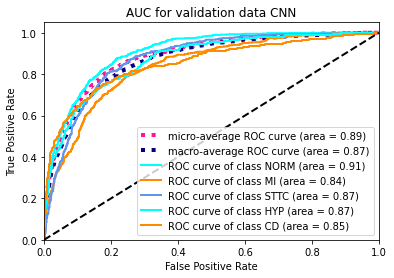

,F_beta_macro,G_beta_macro,macro_auc
0,0.697805,0.400756,0.868703


In [31]:
data = valid_generator
model = load_model('cnn_21thmay.h5')
batches = len(data)
all_true = []
all_pred = []
for batch in tqdm.tqdm(range(batches)):
    xVal, yVal = next(data)
    val_pred = model.predict(xVal)
    val_true = yVal
    all_true.append(val_true)
    all_pred.append(val_pred)
preds_array = np.concatenate(all_pred, axis = 0)
true_array = np.concatenate(all_true, axis = 0)
thresholds = get_thresholds(true=true_array, pred=preds_array)
plotAUC_ROC(true_array, preds_array, superclass_cols, 'validation data CNN')
evaluate_experiment(true_array, preds_array, thresholds=thresholds)

100%|██████████| 68/68 [01:01<00:00,  1.11it/s]

Best Threshold=0.454277, G-Mean=0.820
Best Threshold=0.233414, G-Mean=0.736
Best Threshold=0.228761, G-Mean=0.816
Best Threshold=0.110087, G-Mean=0.771
Best Threshold=0.264590, G-Mean=0.755


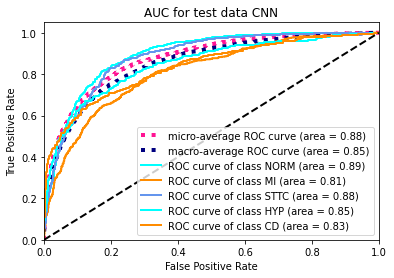

,F_beta_macro,G_beta_macro,macro_auc
0,0.666784,0.370113,0.853667


In [32]:
data = test_generator
model = load_model('cnn_21thmay.h5')
batches = len(data)
all_true = []
all_pred = []
for batch in tqdm.tqdm(range(batches)):
    xVal, yVal = next(data)
    val_pred = model.predict(xVal)
    val_true = yVal
    all_true.append(val_true)
    all_pred.append(val_pred)
preds_array = np.concatenate(all_pred, axis = 0)
true_array = np.concatenate(all_true, axis = 0)
thresholds = get_thresholds(true=true_array, pred=preds_array)
plotAUC_ROC(true_array, preds_array, superclass_cols, 'test data CNN')
evaluate_experiment(true_array, preds_array, thresholds=thresholds)

# RESNET

In [52]:
from keras.applications import resnet
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [108]:
size = (int(761/1), int(2066/1))
train_generator, valid_generator,test_generator = extract_generators(train_datagen, test_datagen,
                                        valid_datagen, size = size, color_mode='rgb' )

Found 17111 validated image filenames.
Found 2163 validated image filenames.
Found 2156 validated image filenames.


In [53]:
base_model = resnet.ResNet50(weights= 'imagenet', include_top=False, input_shape= (761,2066,3))
x = base_model.output
x = Conv2D(filters = 10, kernel_size=(5,5),  strides=(2,2))(x)
x = MaxPooling2D(pool_size = (2,2))(x)
x = Conv2D(filters = 20, kernel_size=(3,3), strides=(1,1))(x)
x = MaxPooling2D(pool_size = (2,2))(x)
x = Flatten()(x)
predictions = (Dense(5, activation='sigmoid'))(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
for layers in base_model.layers:
    layers.trainable = False

In [ ]:
model.compile()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 761, 2066,   0           []                               
                                3)]                                                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 767, 2072, 3  0           ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_conv (Conv2D)            (None, 381, 1033, 6  9472        ['conv1_pad[0][0]']              
                                4)                                                            

In [ ]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)


In [ ]:
mc = ModelCheckpoint('best_model_resnet.h5', monitor='val_accuracy'
                    ,mode='max',save_best_only=True)


In [ ]:
metrics = Metrics(val_data = valid_generator)

In [ ]:
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics='accuracy')

In [ ]:
H = model.fit_generator(train_generator,validation_data=valid_generator,epochs=100,verbose=1,callbacks=[mc, es, metrics])


Epoch 1/100


2022-05-12 17:48:01.498164: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1070/1070 [==============================] - ETA: 0s - loss: 0.3779 - accuracy: 0.6361

2022-05-12 19:26:01.523272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
100%|██████████| 135/135 [14:17<00:00,  6.36s/it]

   F_beta_macro  G_beta_macro  macro_auc
0      0.588985      0.391235   0.862119
1070/1070 [==============================] - 7468s 7s/step - loss: 0.3779 - accuracy: 0.6361 - val_loss: 0.3959 - val_accuracy: 0.6113
Epoch 2/100


1070/1070 [==============================] - ETA: 0s - loss: 0.3528 - accuracy: 0.6536

100%|██████████| 135/135 [14:04<00:00,  6.25s/it]

   F_beta_macro  G_beta_macro  macro_auc
0      0.597362      0.401652   0.855442
1070/1070 [==============================] - 7906s 7s/step - loss: 0.3528 - accuracy: 0.6536 - val_loss: 0.3828 - val_accuracy: 0.6401
Epoch 3/100


1070/1070 [==============================] - ETA: 0s - loss: 0.3387 - accuracy: 0.6619

100%|██████████| 135/135 [14:00<00:00,  6.23s/it]

   F_beta_macro  G_beta_macro  macro_auc
0      0.554134       0.37489   0.860647
1070/1070 [==============================] - 7708s 7s/step - loss: 0.3387 - accuracy: 0.6619 - val_loss: 0.3799 - val_accuracy: 0.6424
Epoch 4/100


1070/1070 [==============================] - ETA: 0s - loss: 0.3219 - accuracy: 0.6709

100%|██████████| 135/135 [14:01<00:00,  6.23s/it]

   F_beta_macro  G_beta_macro  macro_auc
0      0.614527      0.409278   0.872142
1070/1070 [==============================] - 7482s 7s/step - loss: 0.3219 - accuracy: 0.6709 - val_loss: 0.3860 - val_accuracy: 0.6211
Epoch 5/100


1070/1070 [==============================] - ETA: 0s - loss: 0.3159 - accuracy: 0.6780

100%|██████████| 135/135 [14:02<00:00,  6.24s/it]

   F_beta_macro  G_beta_macro  macro_auc
0      0.593944      0.400482    0.86279
1070/1070 [==============================] - 7721s 7s/step - loss: 0.3159 - accuracy: 0.6780 - val_loss: 0.3869 - val_accuracy: 0.6433
Epoch 6/100


1070/1070 [==============================] - ETA: 0s - loss: 0.3076 - accuracy: 0.6883

100%|██████████| 135/135 [14:03<00:00,  6.25s/it]

   F_beta_macro  G_beta_macro  macro_auc
0      0.568221      0.390836   0.869979
1070/1070 [==============================] - 7701s 7s/step - loss: 0.3076 - accuracy: 0.6883 - val_loss: 0.3885 - val_accuracy: 0.6466
Epoch 7/100


1070/1070 [==============================] - ETA: 0s - loss: 0.2945 - accuracy: 0.6963

100%|██████████| 135/135 [13:59<00:00,  6.22s/it]

   F_beta_macro  G_beta_macro  macro_auc
0      0.600025      0.407089    0.87198
1070/1070 [==============================] - 7704s 7s/step - loss: 0.2945 - accuracy: 0.6963 - val_loss: 0.3783 - val_accuracy: 0.6396
Epoch 8/100


1070/1070 [==============================] - ETA: 0s - loss: 0.2871 - accuracy: 0.7015

100%|██████████| 135/135 [13:59<00:00,  6.22s/it]

   F_beta_macro  G_beta_macro  macro_auc
0      0.585821      0.405623   0.871625
1070/1070 [==============================] - 7422s 7s/step - loss: 0.2871 - accuracy: 0.7015 - val_loss: 0.3773 - val_accuracy: 0.6429
Epoch 9/100


1070/1070 [==============================] - ETA: 0s - loss: 0.2762 - accuracy: 0.7090

100%|██████████| 135/135 [15:08<00:00,  6.73s/it]

   F_beta_macro  G_beta_macro  macro_auc
0      0.623485      0.416728   0.869136
1070/1070 [==============================] - 7964s 7s/step - loss: 0.2762 - accuracy: 0.7090 - val_loss: 0.3927 - val_accuracy: 0.6313
Epoch 10/100


1070/1070 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.7200

100%|██████████| 135/135 [14:39<00:00,  6.51s/it]

   F_beta_macro  G_beta_macro  macro_auc
0      0.606406      0.420824   0.873988
1070/1070 [==============================] - 8158s 8s/step - loss: 0.2672 - accuracy: 0.7200 - val_loss: 0.3911 - val_accuracy: 0.6378
Epoch 11/100


1070/1070 [==============================] - ETA: 0s - loss: 0.2612 - accuracy: 0.7256

100%|██████████| 135/135 [17:55<00:00,  7.97s/it]

   F_beta_macro  G_beta_macro  macro_auc
0      0.583795      0.378689   0.852979
1070/1070 [==============================] - 8358s 8s/step - loss: 0.2612 - accuracy: 0.7256 - val_loss: 0.4406 - val_accuracy: 0.6099
Epoch 12/100


1070/1070 [==============================] - ETA: 0s - loss: 0.2499 - accuracy: 0.7350

100%|██████████| 135/135 [13:53<00:00,  6.17s/it]

   F_beta_macro  G_beta_macro  macro_auc
0        0.5743       0.38462   0.864429
1070/1070 [==============================] - 7317s 7s/step - loss: 0.2499 - accuracy: 0.7350 - val_loss: 0.4316 - val_accuracy: 0.6540
Epoch 13/100


1070/1070 [==============================] - ETA: 0s - loss: 0.2414 - accuracy: 0.7440

100%|██████████| 135/135 [14:20<00:00,  6.37s/it]

   F_beta_macro  G_beta_macro  macro_auc
0      0.603546      0.401718    0.85731
1070/1070 [==============================] - 7735s 7s/step - loss: 0.2414 - accuracy: 0.7440 - val_loss: 0.4207 - val_accuracy: 0.6192
Epoch 14/100


1070/1070 [==============================] - ETA: 0s - loss: 0.2343 - accuracy: 0.7492

100%|██████████| 135/135 [14:38<00:00,  6.51s/it]

   F_beta_macro  G_beta_macro  macro_auc
0      0.563073      0.377461   0.855879
1070/1070 [==============================] - 7967s 7s/step - loss: 0.2343 - accuracy: 0.7492 - val_loss: 0.4593 - val_accuracy: 0.6252
Epoch 15/100


1070/1070 [==============================] - ETA: 0s - loss: 0.2253 - accuracy: 0.7567

100%|██████████| 135/135 [14:34<00:00,  6.47s/it]

   F_beta_macro  G_beta_macro  macro_auc
0      0.594518       0.40486   0.857342
1070/1070 [==============================] - 8042s 8s/step - loss: 0.2253 - accuracy: 0.7567 - val_loss: 0.4481 - val_accuracy: 0.6410
Epoch 16/100


   7/1070 [..............................] - ETA: 7:26:01 - loss: 0.2207 - accuracy: 0.7589

## Load and predict

In [34]:
size = (int(761/1), int(2066/1))
train_generator, valid_generator,test_generator = extract_generators(train_datagen, test_datagen,
                                        valid_datagen, size = size, color_mode='rgb' )

Found 17111 validated image filenames.
Found 2163 validated image filenames.
Found 2156 validated image filenames.


100%|██████████| 68/68 [14:59<00:00, 13.23s/it]

Best Threshold=0.646978, G-Mean=0.832
Best Threshold=0.219021, G-Mean=0.768
Best Threshold=0.241506, G-Mean=0.813
Best Threshold=0.022916, G-Mean=0.763
Best Threshold=0.117890, G-Mean=0.772


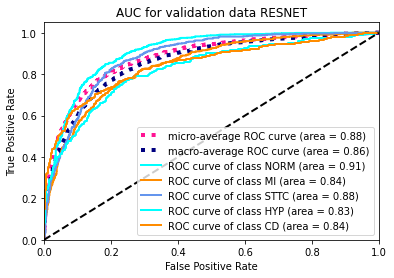

,F_beta_macro,G_beta_macro,macro_auc
0,0.682809,0.391391,0.860271


In [35]:
data = valid_generator
model = load_model('best_model_resnet.h5')
batches = len(data)
all_true = []
all_pred = []
for batch in tqdm.tqdm(range(batches)):
    xVal, yVal = next(data)
    val_pred = model.predict(xVal)
    val_true = yVal
    all_true.append(val_true)
    all_pred.append(val_pred)
preds_array = np.concatenate(all_pred, axis = 0)
true_array = np.concatenate(all_true, axis = 0)
thresholds = get_thresholds(true=true_array, pred=preds_array)
plotAUC_ROC(true_array, preds_array, superclass_cols, 'validation data RESNET')
evaluate_experiment(true_array, preds_array, thresholds=thresholds)

100%|██████████| 68/68 [14:52<00:00, 13.13s/it]

Best Threshold=0.646978, G-Mean=0.832
Best Threshold=0.219021, G-Mean=0.768
Best Threshold=0.241506, G-Mean=0.813
Best Threshold=0.022916, G-Mean=0.763
Best Threshold=0.117890, G-Mean=0.772


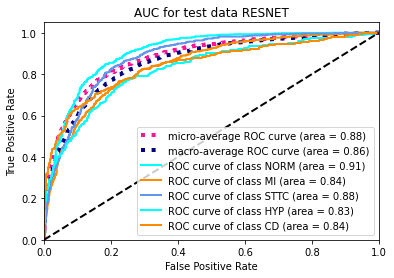

,F_beta_macro,G_beta_macro,macro_auc
0,0.682809,0.391391,0.860271


In [36]:
data = test_generator
model = load_model('best_model_resnet.h5')
batches = len(data)
all_true = []
all_pred = []
for batch in tqdm.tqdm(range(batches)):
    xVal, yVal = next(data)
    val_pred = model.predict(xVal)
    val_true = yVal
    all_true.append(val_true)
    all_pred.append(val_pred)
thresholds = get_thresholds(true=true_array, pred=preds_array)
plotAUC_ROC(true_array, preds_array, superclass_cols, 'test data RESNET')
evaluate_experiment(true_array, preds_array, thresholds=thresholds)

# CNN + LSTM

In [109]:
size = (int(761/2), int(2066/2))
train_generator, valid_generator,test_generator = extract_generators(train_datagen, test_datagen,
                                        valid_datagen, size = size )

Found 17111 validated image filenames.
Found 2163 validated image filenames.
Found 2156 validated image filenames.


In [110]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)


In [111]:
mc = ModelCheckpoint('cnn_lstm_22thmay.h5', monitor='val_accuracy'
                    ,mode='max',save_best_only=True)


In [112]:
metrics = Metrics(val_data = valid_generator)

In [113]:
# define CNN model
from keras.layers.wrappers import TimeDistributed
cnn = Sequential()
cnn.add(Conv2D(filters = 10, kernel_size=(5,5),  kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01),strides=(1,1), input_shape = (*size,  1)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Conv2D(filters = 10, kernel_size=(3,3), strides=(1,1), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Conv2D(filters = 20, kernel_size=(3,3), strides=(1,1), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Conv2D(filters = 20, kernel_size=(5,5), strides=(1,1), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
cnn.add(Conv2D(filters = 20, kernel_size=(5,5), strides=(1,1), kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
cnn.add(MaxPooling2D(pool_size = (2,2)))
# cnn.add(Flatten())
cnn.add(TimeDistributed(Flatten()))
cnn.add(LSTM(32, activation = 'relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
cnn.add(Dense(5, activation='sigmoid'))

In [114]:
cnn.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics='accuracy')

In [115]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 376, 1029, 10)     260       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 188, 514, 10)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 186, 512, 10)      910       
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 93, 256, 10)      0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 91, 254, 20)       1820      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 45, 127, 20)     

In [ ]:
clf = cnn.fit_generator(train_generator,  validation_data=valid_generator, epochs=100, 
                  verbose = 1, callbacks=[mc, es])

Epoch 1/100


2022-05-22 16:06:02.485841: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


535/535 [==============================] - ETA: 0s - loss: 1.0547 - accuracy: 0.4438

2022-05-22 16:13:12.887706: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


535/535 [==============================] - 484s 902ms/step - loss: 1.0547 - accuracy: 0.4438 - val_loss: 0.6683 - val_accuracy: 0.4439
Epoch 2/100
535/535 [==============================] - 491s 917ms/step - loss: 0.6117 - accuracy: 0.4446 - val_loss: 0.5758 - val_accuracy: 0.4439
Epoch 3/100
535/535 [==============================] - 472s 882ms/step - loss: 0.5618 - accuracy: 0.4446 - val_loss: 0.5543 - val_accuracy: 0.4439
Epoch 4/100
535/535 [==============================] - 493s 921ms/step - loss: 0.5530 - accuracy: 0.4446 - val_loss: 0.5545 - val_accuracy: 0.4439
Epoch 5/100
535/535 [==============================] - 471s 880ms/step - loss: 0.5523 - accuracy: 0.4446 - val_loss: 0.5527 - val_accuracy: 0.4439
Epoch 6/100
535/535 [==============================] - 470s 878ms/step - loss: 0.5506 - accuracy: 0.4446 - val_loss: 0.5496 - val_accuracy: 0.4439
Epoch 7/100
535/535 [==============================] - 471s 879ms/step - loss: 0.5497 - accuracy: 0.4446 - val_loss: 0.5494 - val_

## load and predict

In [37]:
size = (int(761/2), int(2066/2))
train_generator, valid_generator,test_generator = extract_generators(train_datagen, test_datagen,
                                        valid_datagen, size = size )

Found 17111 validated image filenames.
Found 2163 validated image filenames.
Found 2156 validated image filenames.


100%|██████████| 68/68 [01:04<00:00,  1.05it/s]

Best Threshold=0.470999, G-Mean=0.461
Best Threshold=0.247609, G-Mean=0.504
Best Threshold=0.240742, G-Mean=0.552
Best Threshold=0.115452, G-Mean=0.705
Best Threshold=0.211995, G-Mean=0.584


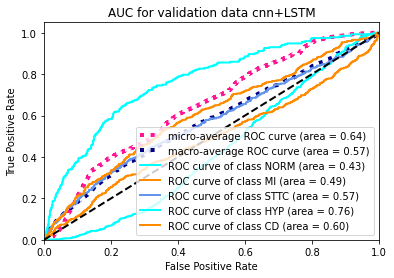

,F_beta_macro,G_beta_macro,macro_auc
0,0.477571,0.215697,0.568895


In [38]:
data = valid_generator
model = load_model('cnn_lstm_22thmay.h5')
batches = len(data)
all_true = []
all_pred = []
for batch in tqdm.tqdm(range(batches)):
    xVal, yVal = next(data)
    val_pred = model.predict(xVal)
    val_true = yVal
    all_true.append(val_true)
    all_pred.append(val_pred)
preds_array = np.concatenate(all_pred, axis = 0)
true_array = np.concatenate(all_true, axis = 0)
thresholds = get_thresholds(true=true_array, pred=preds_array)
plotAUC_ROC(true_array, preds_array, superclass_cols, 'validation data cnn+LSTM')
evaluate_experiment(true_array, preds_array, thresholds=thresholds)

100%|██████████| 68/68 [01:04<00:00,  1.06it/s]


Best Threshold=0.471000, G-Mean=0.469
Best Threshold=0.247585, G-Mean=0.510
Best Threshold=0.240657, G-Mean=0.560
Best Threshold=0.115518, G-Mean=0.693
Best Threshold=0.212060, G-Mean=0.571


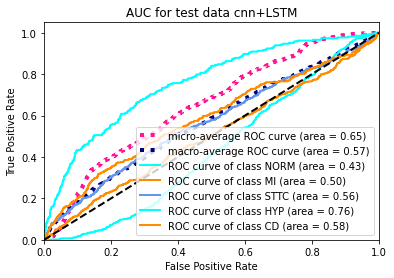

,F_beta_macro,G_beta_macro,macro_auc
0,0.474346,0.214451,0.568319


In [39]:
data = test_generator
model = load_model('cnn_lstm_22thmay.h5')
batches = len(data)
all_true = []
all_pred = []
for batch in tqdm.tqdm(range(batches)):
    xVal, yVal = next(data)
    val_pred = model.predict(xVal)
    val_true = yVal
    all_true.append(val_true)
    all_pred.append(val_pred)
preds_array = np.concatenate(all_pred, axis = 0)
true_array = np.concatenate(all_true, axis = 0)
thresholds = get_thresholds(true=true_array, pred=preds_array)
plotAUC_ROC(true_array, preds_array, superclass_cols, 'test data cnn+LSTM')
evaluate_experiment(true_array, preds_array, thresholds=thresholds)

# Inception net

In [ ]:
size = (256, 256)
train_generator, valid_generator,test_generator = extract_generators(train_datagen, test_datagen,
                                        valid_datagen, size = size, color_mode='rgb' )

In [40]:
from tensorflow.keras.applications import resnet, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [45]:
input_shape_ = (256, 256, 3)
seed = 42
base_model = InceptionV3(weights= 'imagenet', include_top=False, input_shape= input_shape_)

In [46]:
# # define CNN model
model=base_model.output
# cnn = Sequential()

model = Conv2D(filters = 50, kernel_size=(5,5),  strides=2, input_shape = input_shape_,
                activation=tf.keras.layers.LeakyReLU(alpha=0.3), padding='same',
                kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed))(model)
model = MaxPooling2D(pool_size = (2,2), padding='same',)(model)
model = Dropout(0.3)(model)

model = Conv2D(filters = 30, kernel_size=(5,5),  strides=2, 
                activation=tf.keras.layers.LeakyReLU(alpha=0.3), padding='same',
                kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed))(model)
model = MaxPooling2D(pool_size = (2,2), padding='same',)(model)
model = Dropout(0.3)(model)

model = Conv2D(filters = 20, kernel_size=(3,3), strides=2,
                activation=tf.keras.layers.LeakyReLU(alpha=0.3), padding='same',
                kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed))(model)
model = MaxPooling2D(pool_size = (2,2), padding='same',)(model)
model = Dropout(0.2)(model)

model = Conv2D(filters = 10, kernel_size=(3,3), strides=2, 
               activation=tf.keras.layers.LeakyReLU(alpha=0.3), padding='same',
               kernel_initializer=tf.keras.initializers.GlorotNormal(seed=seed))(model)
model = MaxPooling2D(pool_size = (2,2), padding='same',)(model)
model = Dropout(0.2)(model)

model = Flatten()(model)
predictions =  Dense(5, activation='sigmoid')(model)
model = Model(inputs = base_model.input, outputs = predictions)

In [47]:
for i in range(50):
    base_model.layers[i].trainable = False

In [50]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10)

mc = ModelCheckpoint('best_model_inception_50freeze.h5', monitor='val_accuracy'
                    ,mode='max',save_best_only=True)

metrics = Metrics(val_data = valid_generator)

In [51]:
model.compile(optimizer='Adam', loss = 'binary_crossentropy', metrics='accuracy')

In [ ]:
H = model.fit_generator(train_generator,validation_data=valid_generator,
                        epochs=100,verbose=1,callbacks=[mc, es])

Epoch 1/100


2022-05-22 18:34:05.291510: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-05-22 18:34:07.795798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


268/268 [==============================] - ETA: 0s - loss: 0.4762 - accuracy: 0.4992

2022-05-22 18:44:13.572584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


268/268 [==============================] - 656s 2s/step - loss: 0.4762 - accuracy: 0.4992 - val_loss: 0.7197 - val_accuracy: 0.3340
Epoch 2/100
268/268 [==============================] - 721s 3s/step - loss: 0.4003 - accuracy: 0.5885 - val_loss: 0.7653 - val_accuracy: 0.5487
Epoch 3/100
268/268 [==============================] - 748s 3s/step - loss: 0.3758 - accuracy: 0.6141 - val_loss: 0.3941 - val_accuracy: 0.5881
Epoch 4/100
268/268 [==============================] - 556s 2s/step - loss: 0.3550 - accuracy: 0.6337 - val_loss: 0.6523 - val_accuracy: 0.5737
Epoch 5/100
268/268 [==============================] - 1145s 4s/step - loss: 0.3389 - accuracy: 0.6581 - val_loss: 0.6202 - val_accuracy: 0.5645
Epoch 6/100
268/268 [==============================] - 518s 2s/step - loss: 0.3200 - accuracy: 0.6770 - val_loss: 0.5286 - val_accuracy: 0.6169
Epoch 7/100
268/268 [==============================] - 573s 2s/step - loss: 0.3019 - accuracy: 0.6888 - val_loss: 0.4039 - val_accuracy: 0.6127
Epo

## Load and predict

In [52]:
size = (256, 256)
train_generator, valid_generator,test_generator = extract_generators(train_datagen, test_datagen,
                                        valid_datagen, size = size, color_mode='rgb' )

Found 17111 validated image filenames.
Found 2163 validated image filenames.
Found 2156 validated image filenames.


100%|██████████| 68/68 [01:13<00:00,  1.09s/it]

Best Threshold=0.867595, G-Mean=0.823
Best Threshold=0.208826, G-Mean=0.771
Best Threshold=0.026715, G-Mean=0.736
Best Threshold=0.023062, G-Mean=0.766
Best Threshold=0.133056, G-Mean=0.773


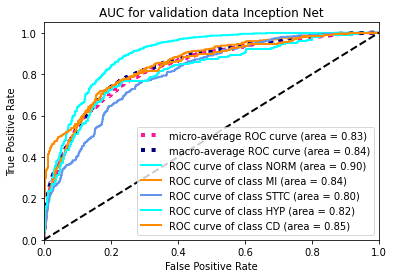

,F_beta_macro,G_beta_macro,macro_auc
0,0.652116,0.364176,0.840665


In [55]:
data = valid_generator
model = load_model('best_model_inception_50freeze.h5')
batches = len(data)
all_true = []
all_pred = []
for batch in tqdm.tqdm(range(batches)):
    xVal, yVal = next(data)
    val_pred = model.predict(xVal)
    val_true = yVal
    all_true.append(val_true)
    all_pred.append(val_pred)
preds_array = np.concatenate(all_pred, axis = 0)
true_array = np.concatenate(all_true, axis = 0)
thresholds = get_thresholds(true=true_array, pred=preds_array)
plotAUC_ROC(true_array, preds_array, superclass_cols, 'validation data Inception Net')
evaluate_experiment(true_array, preds_array, thresholds=thresholds)

100%|██████████| 68/68 [01:13<00:00,  1.09s/it]

Best Threshold=0.871738, G-Mean=0.808
Best Threshold=0.238455, G-Mean=0.757
Best Threshold=0.023564, G-Mean=0.748
Best Threshold=0.022880, G-Mean=0.767
Best Threshold=0.087897, G-Mean=0.748


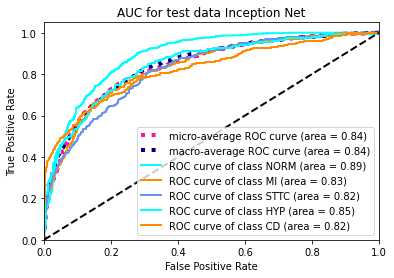

,F_beta_macro,G_beta_macro,macro_auc
0,0.642909,0.347884,0.841648


In [56]:
data = test_generator
model = load_model('best_model_inception_50freeze.h5')
batches = len(data)
all_true = []
all_pred = []
for batch in tqdm.tqdm(range(batches)):
    xVal, yVal = next(data)
    val_pred = model.predict(xVal)
    val_true = yVal
    all_true.append(val_true)
    all_pred.append(val_pred)
preds_array = np.concatenate(all_pred, axis = 0)
true_array = np.concatenate(all_true, axis = 0)
thresholds = get_thresholds(true=true_array, pred=preds_array)
plotAUC_ROC(true_array, preds_array, superclass_cols, 'test data Inception Net')
evaluate_experiment(true_array, preds_array, thresholds=thresholds)